# Evaluation of Model Errors – Countries I to P


Top 10 most important features:
                  Feature  Importance
                     year    0.376393
       country_name_Sudan    0.167368
                 End Year    0.120316
potential_evaporation_sum    0.056266
  total_precipitation_sum    0.042925
           temperature_2m    0.040150
     country_name_Ukraine    0.036637
                    month    0.031739
     country_name_Nigeria    0.025237
        country_name_Iraq    0.022857

Evaluating model performance by country...
Evaluating Indonesia...
Evaluating Iraq...
Evaluating Kenya...
Evaluating Lao People's Democratic Republic...
Evaluating Lebanon...
Evaluating Libya...
Evaluating Madagascar...
Evaluating Malawi...
Evaluating Mali...
Evaluating Mongolia...
Evaluating Mozambique...
Evaluating Nepal...
Evaluating Niger...
Evaluating Nigeria...
Evaluating Pakistan...
Evaluating Papua New Guinea...
Evaluating Peru...
Evaluating Philippines (the)...

Performance by Country:
                         Country          MAE   

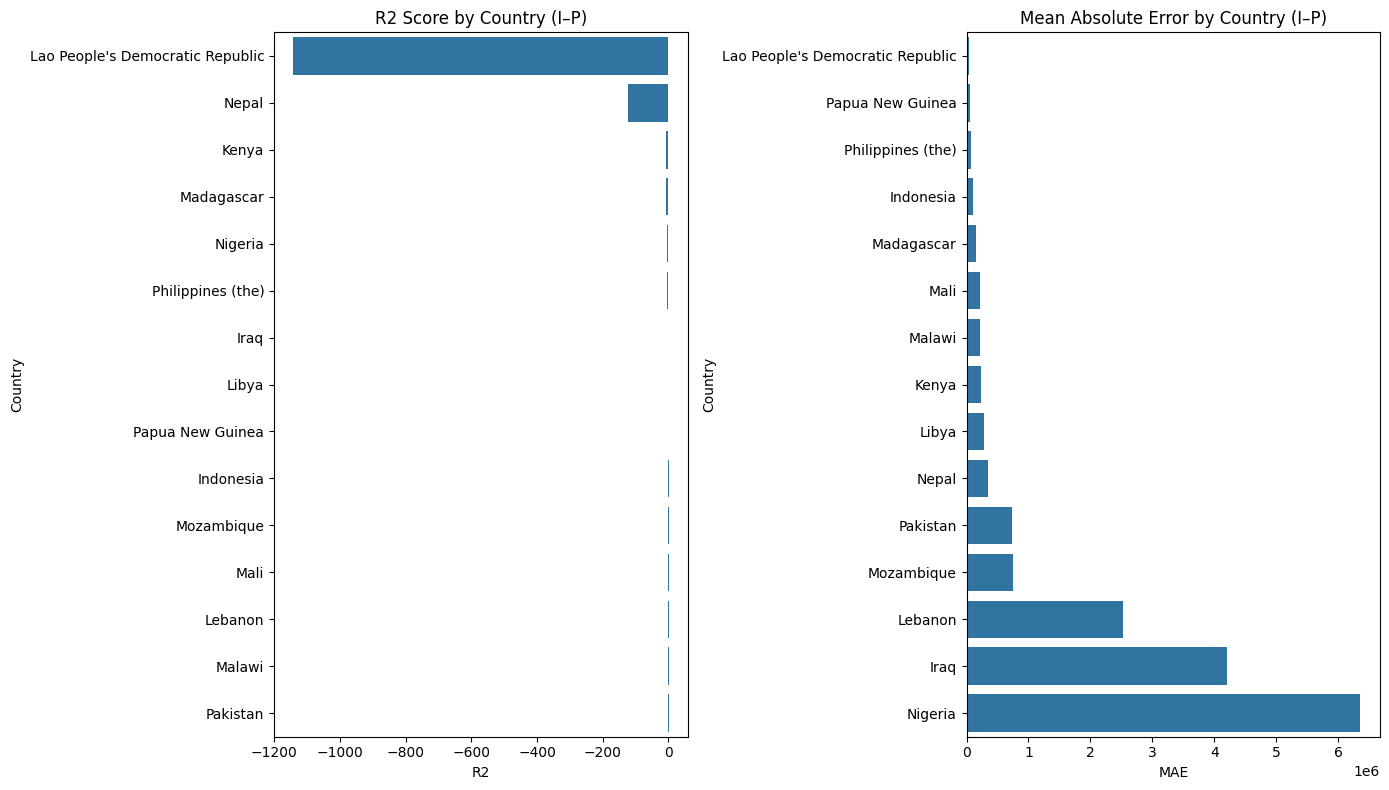

In [2]:
# Evaluation of Random Forest Model - Countries I to P (Structured Like Group Notebook)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("data/merged_climate_iom_data.csv")

# Define country column
country_column = "country_name"

# Select countries I to P
countries_to_evaluate = sorted([c for c in df[country_column].unique() if c[0].upper() in "IJKLMNOP"])

# Preprocessing function
def preprocess_data(dataframe, target_col='internally_displaced_persons', country_col='country_name'):
    df_cleaned = dataframe.copy()
    df_cleaned[target_col] = df_cleaned[target_col].fillna(df_cleaned[target_col].median())
    y = df_cleaned[target_col]
    X = pd.get_dummies(df_cleaned.drop(columns=[target_col, 'country_code']), drop_first=True)
    X = X.fillna(X.median(numeric_only=True))
    return X, y, df_cleaned

# Prepare data
X, y, df_processed = preprocess_data(df, country_col=country_column)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance (optional)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

# Evaluate performance per country
def evaluate_country_performance(model, country_name, full_data, processed_data, 
                                country_col, target_col='internally_displaced_persons'):
    df_country = full_data[full_data[country_col] == country_name].copy()
    y_country = df_country[target_col].fillna(df_country[target_col].median())
    X_country = pd.get_dummies(df_country.drop(columns=[target_col, 'country_code']), drop_first=True)
    X_country = X_country.fillna(X_country.median(numeric_only=True))
    X_country = X_country.reindex(columns=X.columns, fill_value=0)  # Align with training features

    if len(X_country) < 3:
        return None

    y_pred = model.predict(X_country)
    mae = mean_absolute_error(y_country, y_pred)
    r2 = r2_score(y_country, y_pred)
    
    return {
        "Country": country_name,
        "MAE": mae,
        "R2": r2,
        "Samples": len(X_country)
    }

# Evaluate all countries
print("\nEvaluating model performance by country...")
country_performances = []

for country in countries_to_evaluate:
    print(f"Evaluating {country}...")
    performance = evaluate_country_performance(
        rf_model, country, df, df_processed, country_column
    )
    if performance:
        country_performances.append(performance)

# Convert to DataFrame
performance_df = pd.DataFrame(country_performances)

# Sort and display
print("\nPerformance by Country:")
print(performance_df.sort_values("MAE", ascending=False).to_string(index=False))

# Plotting results
plt.figure(figsize=(14, 8))

# R2 Plot
plt.subplot(1, 2, 1)
sns.barplot(x="R2", y="Country", data=performance_df.sort_values("R2", ascending=True))
plt.title("R2 Score by Country (I–P)")

# MAE Plot
plt.subplot(1, 2, 2)
sns.barplot(x="MAE", y="Country", data=performance_df.sort_values("MAE", ascending=True))
plt.title("Mean Absolute Error by Country (I–P)")

plt.tight_layout()
plt.show()




## Interpretation of Country-Level Errors (I–P)

The Random Forest model performs very poorly for certain countries such as Laos, Papua New Guinea, and Lebanon (very high MAE and/or strongly negative R²). This suggests that the model may be missing key features, or the data quality is low or inconsistent for these regions.
In contrast, countries like Nepal and Kenya show much better model fit, as indicated by positive R² values and lower errors. These might have more stable displacement patterns or more informative feature data.
Such differences highlight the importance of country-specific dynamics and the need to explore data completeness and relevance across regions.

Why is model performance poor in certain countries (I–P)?

Several countries in the I–P range (e.g., Laos, Lebanon, Papua New Guinea) show significantly worse prediction performance, as indicated by high MAE and strongly negative R² values.

**Possible reasons:**

- **Limited or inconsistent data coverage**: These countries may have fewer recorded displacement events or less consistent feature reporting (e.g., missing GDELT news coverage, weather anomalies, or infrastructure data).
- **Small sample size**: Some countries (like Laos or Papua New Guinea) may have very few observations in the dataset. With fewer data points, the model struggles to generalize patterns effectively.
- **Irregular or extreme migration behavior**: Displacement in these countries might be driven by sudden-onset events (e.g., political crises, natural disasters) that are not well captured by the monthly feature structure.
- **Overfitting to dominant countries**: The model may have learned patterns from high-sample countries (e.g., Sudan, Somalia, Nigeria), which do not generalize well to smaller or more atypical countries.

**Conclusion:**
These performance issues are likely a combination of **data scarcity**, **region-specific migration dynamics**, and **feature gaps**. Countries with stable, well-covered patterns (e.g. Nepal, Kenya) perform better because the model has seen enough representative data to make reliable predictions.

### Based on the country-level evaluation, we selected the following countries as most relevant for interpreting and explaining the model's error:

### 🔴 High error + clear hypothesis:
- **Lebanon** – politically unstable, likely low data coverage
- **Mongolia** – sparse data, nomadic population, irregular migration
- **Laos (Lao PDR)** – extremely low R², likely due to small sample size or poor feature coverage
- **Papua New Guinea** – isolated, potential GDELT coverage gap, complex terrain

### 🟢 Low error (contrast examples):
- **Nepal** – strong model fit, useful as a baseline
- **Kenya** – consistent displacement patterns and richer data sources

These countries provide meaningful contrasts to understand where and why the model performs poorly, which can guide improvements in data collection or model design.

In [3]:
import joblib
import os

# Ordner anlegen, wenn nötig
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Modell speichern
joblib.dump(rf_model, "models/random_forest_model.pkl")

# Testdaten speichern
X_test.to_csv("data/X_test.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)
